In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers, utils, initializers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import linkpred
from linkpred.evaluation import Pair
import seaborn as sns

In [4]:
import sklearn.metrics as metrics

In [5]:
from gensim.models import Word2Vec

In [6]:
with open('universe_1057.pickle', 'rb') as f:
    universe_1057 = pickle.load(f)

In [7]:
with open('universe_597.pickle', 'rb') as f:
    universe_597 = pickle.load(f)

In [8]:
len(universe_597)

3160

In [9]:
embedding_pickle_597 = pd.read_pickle('embedding_pickle_597.csv')

In [10]:
edges_597 = pd.read_pickle('edges_original_597.csv')

In [11]:
embedding_pickle_1057 = pd.read_pickle('embedding_pickle_1057.csv')

In [12]:
edges_1057 = pd.read_pickle('edges_original_1057.csv')

In [13]:
H_597 = nx.read_graphml("H_597.graphml")

In [14]:
all_unconnected_pairs_597 = []

In [15]:
def check_isequal(x, a, b):
    if x[0] == a:
        if x[1] == b:
            return True
    if x[1] == a:
        if x[0] == b:
            return True
    return False

In [16]:
for ui in universe_597:
    is_not = False
    for i,j in edges_597.values:
        if check_isequal(ui, i, j):
            is_not = True
            break
    if not is_not:
        all_unconnected_pairs_597.append((ui[0], ui[1]))

In [17]:
len(all_unconnected_pairs_597)

1908

In [18]:
word2vec_597 = Word2Vec.load("word2vec_597.model")

Collegamenti inesistenti => target negativo

In [19]:
node_1_unlinked = [word2vec_597.wv[i[0]] for i in all_unconnected_pairs_597]
node_2_unlinked = [word2vec_597.wv[i[1]] for i in all_unconnected_pairs_597]

data_597 = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data_597['link'] = 0

In [20]:
data_597

,node_1,node_2,link
0,"[-0.0030631882, 0.008616773, -0.0045523765, 0....","[-0.001554146, -0.0012236267, -0.0026807743, -...",0
1,"[0.0022856512, 0.006231843, -0.0096024, -0.001...","[0.007664479, 0.004021384, -0.002702067, 0.009...",0
2,"[0.0058875037, -0.00839095, -0.007141535, -0.0...","[-0.0074241604, -0.0012602279, 0.009695181, -0...",0
3,"[-0.0017582083, -0.0034002608, -0.004141071, -...","[-0.0064709443, -0.00025158245, -0.009321352, ...",0
4,"[0.0022856512, 0.006231843, -0.0096024, -0.001...","[0.005889654, 0.00078929117, 0.005454147, 0.00...",0
...,...,...,...
1903,"[0.0017936621, -0.00034908883, 0.0077299355, 0...","[-0.009829871, 0.0017744834, -0.0053669345, 0....",0
1904,"[-0.0033032289, -0.008142593, 0.009370617, -0....","[0.007260275, 0.0014188879, -0.0073164664, 0.0...",0
1905,"[-0.0032215626, -0.0003636058, 9.800874e-06, -...","[0.0018837609, 0.0034408027, -0.009308512, -0....",0
1906,"[0.008844223, 0.0013586662, -0.0043488606, 0.0...","[-0.0007017409, 0.009480938, 0.0040279943, 0.0...",0


In [21]:
def omissibile_links(G, df_edges):
    initial_node_count = len(G.nodes)

    fb_df_temp = df_edges.copy()

    # empty list to store removable links
    omissible_links_index = []

    for i in tqdm(df_edges.index.values):

      # remove a node pair and build a new graph
      G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "first", "second", create_using=nx.Graph())

      # check there is no spliting of graph and number of nodes is same
      if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)
    return omissible_links_index

In [22]:
omissible_links_597 =  omissibile_links(H_597, edges_597)

100%|█████████████████████████████████████████████████████████████████████████████| 1252/1252 [00:02<00:00, 585.72it/s]


In [23]:
len(edges_597)

1252

In [24]:
len(omissible_links_597)

1173

In [25]:
len(universe_597)

3160

In [26]:
# create dataframe of removable edges
fb_df_ghost_597 = embedding_pickle_597.loc[omissible_links_597]

fb_df_ghost_597 = fb_df_ghost_597.rename(columns={"first": "node_1", "second": "node_2"})
# add the target variable 'link'
fb_df_ghost_597['link'] = 1

data_597 = data_597.append(fb_df_ghost_597[['node_1', 'node_2', 'link']], ignore_index=True)

In [27]:
data_597['link'].value_counts()

0    1908
1    1173
Name: link, dtype: int64

In [28]:
data_597.to_pickle("data_597.csv")

----------------- Lettura dati -------------------

In [29]:
data_597 = pd.read_pickle('data_597.csv')

# 2 - Classificatori

In [30]:
X_597 = []
for i in range(data_597.shape[0]):
    first = data_597.iloc[i][0]
    second = data_597.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_597.append(mixed)

In [31]:
xtrain_597, xtest_597, ytrain_597, ytest_597 = train_test_split(np.asarray(X_597), data_597['link'], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=data_597['link'])

### 1 - DecisionTree

In [32]:
from sklearn import tree
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [33]:
# Set the parameters by cross-validation
tuned_parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
}
scores = ['roc_auc']

In [34]:
def builtGridSearch( X_train, X_test, y_train, y_test, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("------- Score = " + str(score) + " ------- \n")
        model = tree.DecisionTreeClassifier()
        k_fold = StratifiedKFold(n_splits=5, random_state=42)
        
        print("> Fold = " + str(k_fold) + "\n")
        clf = GridSearchCV(model, tuned_parameters, error_score='raise', cv=5, scoring = score, return_train_score=True)

        clf.fit(X_train, y_train)

        print("> Best Parameter set: \n")
        best = clf.best_params_
        print(best)
        
        print("\n> Grid scores:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
        parameters = {"criterion": [], "max_depth": [], "min_samples_leaf": [], "min_samples_split": []}
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
            parameters["criterion"].append(params["criterion"])

            if(params["max_depth"] == None):
                parameters["max_depth"].append(0)
            else:
                parameters["max_depth"].append(params["max_depth"])

            #parameters["max_depth"].append(params["max_depth"])
            parameters["min_samples_leaf"].append(params["min_samples_leaf"])
            parameters["min_samples_split"].append(params["min_samples_split"])
        
        print("-> Report\n") 
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print("\n")
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))

        
        # Creazione del csv
        d = {score: means, 'std_dev': stds*2, 'criterion': parameters["criterion"], "max_depth": parameters["max_depth"], "min_samples_leaf": parameters["min_samples_leaf"], "min_samples_split": parameters["min_samples_split"]}
        
        dataF = pd.DataFrame(data=d)
        
        dataF.to_csv("result_DT_gridsearch.csv",index=False, header=True)
        

        print("...........RESULTS FOR TRAINING.........")
        print("........................................")
        means = clf.cv_results_['mean_train_score']
        stds = clf.cv_results_['std_train_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))        
        
        print("____________________________________________")
        
        optimals[score] = best
    return optimals

In [35]:
optimals_597 = builtGridSearch(xtrain_597, xtest_597, ytrain_597, ytest_597, tuned_parameters, scores)

------- Score = roc_auc ------- 



ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [ ]:
optimals_597

In [ ]:
model_597 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
model_597.fit(xtrain_597, ytrain_597)
y_pred_597 = model_597.predict(xtest_597)

In [ ]:
y_score_597 = model_597.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score_597[:, 1])
roc_auc0_597 = auc(fpr0, tpr0)

In [ ]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0_597))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 1 - DecisionTree_Bilanciato

In [36]:
remove_n = data_597['link'].value_counts()[0] - data_597['link'].value_counts()[1]
remove_n

735

In [37]:
df = data_597.copy()
drop_indices = np.random.choice(df[df["link"]==0].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
print(df_subset['link'].value_counts())

X_sbset_597 = []
for i in range(df_subset.shape[0]):
    first = df_subset.iloc[i][0]
    second = df_subset.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_sbset_597.append(mixed)
    
    
xtrain_sb_597, xtest_sb_597, ytrain_sb_597, ytest_sb_597 = train_test_split(np.asarray(X_sbset_597), df_subset["link"], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=df_subset["link"])

0    1173
1    1173
Name: link, dtype: int64


In [38]:
optimals_sb_597 = builtGridSearch(xtrain_sb_597, xtest_sb_597, ytrain_sb_597, ytest_sb_597, tuned_parameters, scores)

------- Score = roc_auc ------- 



ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [39]:
model_sb_597 = tree.DecisionTreeClassifier(criterion = "gini", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
model_sb_597.fit(xtrain_sb_597, ytrain_sb_597)

DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=10)

In [40]:
y_score_sb_597 = model_sb_597.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score_sb_597[:, 1])
roc_auc0_dt_597_sb = auc(fpr0, tpr0)

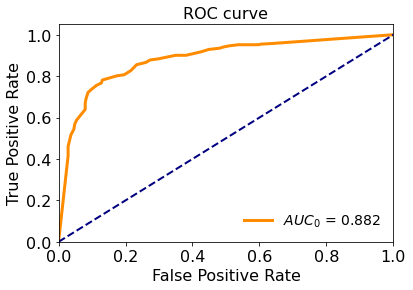

In [41]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0_dt_597_sb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 2 - Regressione logistica

In [42]:
lr = LogisticRegression()
lr.fit(xtrain_597, ytrain_597)
predictions = lr.predict_proba(xtest_597)

In [43]:
y_score = lr.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

0.8748264715214977


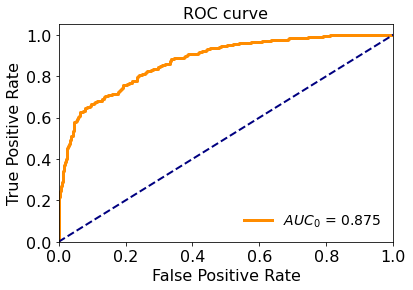

In [44]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 2 - Regressione Logistica_Bilanciata

In [45]:
lr = LogisticRegression()
lr.fit(xtrain_sb_597, ytrain_sb_597)

LogisticRegression()

In [46]:
y_score = lr.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

0.8838455578512396


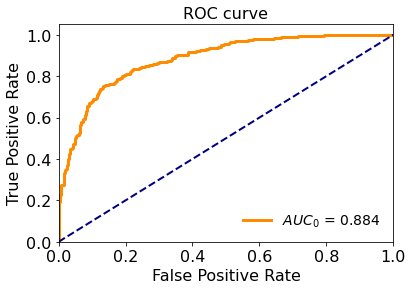

In [47]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 3 - LGBM

In [48]:
new_xtrain_597, xval_597, new_ytrain_597, yval_597 = train_test_split(xtrain_597, ytrain_597, 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=ytrain_597)

In [49]:
import lightgbm as lgbm

In [50]:
train_data = lgbm.Dataset(new_xtrain_597, new_ytrain_597)
test_data = lgbm.Dataset(xval_597, yval_597)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

y_pred = model.predict(xtest_597)

C:\Users\marco\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 575, number of negative: 934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15714
[LightGBM] [Info] Number of data points in the train set: 1509, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381047 -> initscore=-0.485106
[LightGBM] [Info] Start training from score -0.485106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.803874
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.824296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.850992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.872382
[LightGBM] [Warning] No further s

In [51]:
y_pred

array([0.02784735, 0.03451315, 0.93262568, 0.87076399, 0.03276709,
       0.02684692, 0.96023263, 0.07250399, 0.56716608, 0.0727544 ,
       0.85233175, 0.94653231, 0.82921796, 0.55859149, 0.03487478,
       0.37539393, 0.02767673, 0.8328968 , 0.95836849, 0.56808066,
       0.29780355, 0.95320167, 0.16035027, 0.92625521, 0.91498906,
       0.76836766, 0.18164972, 0.6480838 , 0.58091546, 0.08415868,
       0.96605965, 0.12935268, 0.0585266 , 0.61983314, 0.75294517,
       0.4650537 , 0.32606865, 0.03121468, 0.02340865, 0.04212751,
       0.66754839, 0.88417749, 0.5767976 , 0.07455013, 0.81368593,
       0.30900359, 0.09931975, 0.77451057, 0.16054006, 0.07597932,
       0.13061675, 0.51658192, 0.16975247, 0.92887351, 0.05136405,
       0.38646086, 0.88033852, 0.04427943, 0.07095067, 0.11286805,
       0.19263879, 0.93957917, 0.19049568, 0.07729283, 0.10687245,
       0.06886669, 0.58562254, 0.81723155, 0.7948343 , 0.11607752,
       0.03312402, 0.03482923, 0.07880838, 0.39162854, 0.02091

In [52]:
fpr0, tpr0, _ = roc_curve(ytest_597, y_pred)
roc_auc_lgbm = auc(fpr0, tpr0)
print(roc_auc_lgbm)

0.9378073933047755


### 3 - LGBM_Bilanciato

In [53]:
new_xtrain_sb_597, xval_sb_597, new_ytrain_sb_597, yval_sb_597 = train_test_split(xtrain_sb_597, ytrain_sb_597, 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=ytrain_sb_597)

In [54]:
train_data = lgbm.Dataset(new_xtrain_sb_597, new_ytrain_sb_597)
test_data = lgbm.Dataset(xval_sb_597, yval_sb_597)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)
y_pred = model.predict(xtest_sb_597)

C:\Users\marco\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 574, number of negative: 575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15634
[LightGBM] [Info] Number of data points in the train set: 1149, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499565 -> initscore=-0.001741
[LightGBM] [Info] Start training from score -0.001741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.822373
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.849536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.854588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.872552
[LightGBM] [Warning] No further s

In [55]:
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_pred)
roc_auc_lgbm_sb = auc(fpr0, tpr0)
print(roc_auc_lgbm_sb)

0.9337551652892562


### 3 - LinearSVC

In [56]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [57]:
# Set the parameters by cross-validation
tuned_parameters = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0)
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

scores = ['roc_auc']

def gridsearch_linearsvc(X_train, y_train, X_test, y_test, k_fold, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("# Tuning hyper-parameters for ----> %s" % score)
        print()

        svm = LinearSVC()

        clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)

        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))
        print("____________________________________________")
        optimals[score] = clf.best_params_
    return optimals

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [58]:
optimals_597 = gridsearch_linearsvc(xtrain_597, ytrain_597, xtest_597, ytest_597, k_fold, tuned_parameters, scores)

NameError: name 'gridsearch_linearsvc' is not defined

In [59]:
optimals_597

NameError: name 'optimals_597' is not defined

0.9496916151039188


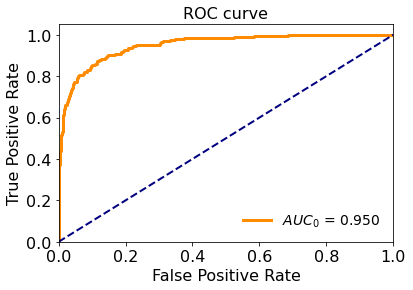

In [60]:
model_597 = LinearSVC(C = 100.0, tol =1.0)
model_597.fit(xtrain_597, ytrain_597)


y_score_597 = model_597.predict(xtest_597)

cclf = CalibratedClassifierCV(base_estimator=model_597, cv=5)
cclf.fit(xtrain_597, ytrain_597)
y_pred = cclf.predict(xtest_597)
y_score_597 = cclf.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score_597[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 3 - LinearSVC_Bilanciato

In [61]:
optimals_sb_597 = gridsearch_linearsvc(xtrain_sb_597, ytrain_sb_597, xtest_sb_597, ytest_sb_597, k_fold, tuned_parameters, scores)

NameError: name 'gridsearch_linearsvc' is not defined

In [ ]:
optimals_sb_597

In [ ]:
model_sb_597 = LinearSVC(C = 10.0, tol =0.1)
model_sb_597.fit(xtrain_sb_597, ytrain_sb_597)


y_score_sb_597 = model_sb_597.predict(xtest_sb_597)

cclf = CalibratedClassifierCV(base_estimator=model_sb_597, cv=5)
cclf.fit(xtrain_sb_597, ytrain_sb_597)
y_pred = cclf.predict(xtest_sb_597)
y_score_sb_597 = cclf.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score_sb_597[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 4 - NN

In [62]:
def build_model_1( X_train):
    optimizer='adagrad'
    #optimizer='adam'
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["AUC"])
    return model

In [63]:
def build_model_2(X_train):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
    sgd = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["AUC"])
    return model

In [64]:
model1_597 = build_model_1(xtrain_597)
history1_597 = model1_597.fit(xtrain_597, ytrain_597, validation_data=(xtest_597, ytest_597), epochs=30, batch_size=10).history

model2_597 = build_model_2(xtrain_597)
history2_597 = model2_597.fit(xtrain_597, ytrain_597, validation_data=(xtest_597, ytest_597), epochs=30, batch_size=50).history

Epoch 1/30
216/216 [==============================] - 2s 5ms/step - loss: 0.6731 - auc: 0.4919 - val_loss: 0.6660 - val_auc: 0.5096
Epoch 2/30
216/216 [==============================] - 1s 3ms/step - loss: 0.6654 - auc: 0.4741 - val_loss: 0.6645 - val_auc: 0.5129
Epoch 3/30
216/216 [==============================] - 1s 3ms/step - loss: 0.6647 - auc: 0.4940 - val_loss: 0.6642 - val_auc: 0.5079
Epoch 4/30
216/216 [==============================] - 1s 3ms/step - loss: 0.6645 - auc: 0.4959 - val_loss: 0.6641 - val_auc: 0.5206
Epoch 5/30
216/216 [==============================] - 1s 3ms/step - loss: 0.6645 - auc: 0.4970 - val_loss: 0.6641 - val_auc: 0.5225
Epoch 6/30
216/216 [==============================] - 1s 3ms/step - loss: 0.6644 - auc: 0.5145 - val_loss: 0.6640 - val_auc: 0.5182
Epoch 7/30
216/216 [==============================] - 1s 2ms/step - loss: 0.6644 - auc: 0.5020 - val_loss: 0.6640 - val_auc: 0.5207
Epoch 8/30
216/216 [==============================] - 1s 3ms/step - loss: 0.

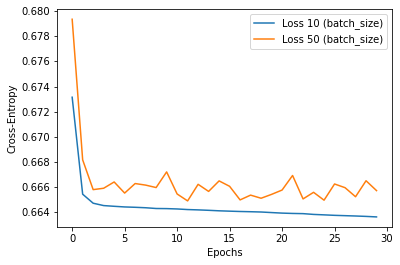

In [65]:
plt.plot(history1_597['loss'], label='Loss 10 (batch_size)')
plt.plot(history2_597['loss'], label='Loss 50 (batch_size)')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

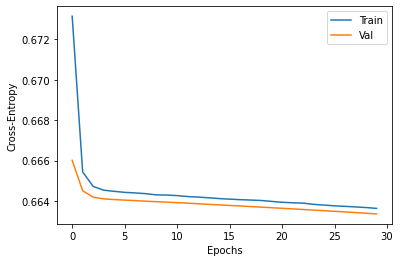

In [66]:
plt.plot(history1_597['loss'], label='Train')
plt.plot(history1_597['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

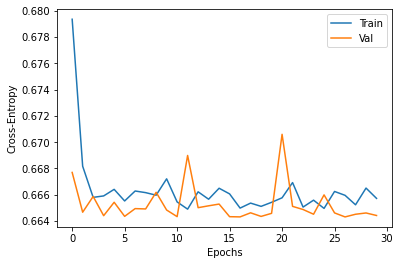

In [67]:
plt.plot(history2_597['loss'], label='Train')
plt.plot(history2_597['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [68]:
test_loss_1_597, test_auc_1_597 = model1_597.evaluate(xtest_597, ytest_597)
test_loss_2_597, test_auc_2_597 = model2_597.evaluate(xtest_597, ytest_597)

print('Loss %f, AUC %f' % (test_loss_1_597, test_auc_1_597))
print('Loss %f, AUC %f' % (test_loss_2_597, test_auc_2_597))

29/29 [==============================] - 0s 2ms/step - loss: 0.6644 - auc: 0.5000
Loss 0.663353, AUC 0.563080
Loss 0.664419, AUC 0.500000


In [69]:
def create_model(X_train, learning_rate=0.1, momentum = 0.9, nesterov = True,
                 activation = 'sigmoid', regularizer = 0.01, units=3, hidden_layers=1):
    # create model
    model = Sequential()
    #initializer = initializers.RandomUniform(minval=0, maxval=0.5, seed=None)
    model.add(Dense(units, input_dim=X_train.shape[1], activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    for i in range(1,hidden_layers):
          model.add(Dense(units, activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    model.add(Dense(1, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(regularizer)))
    sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['AUC'])
    return model

In [70]:
param_list = {'batch_size': [128],
              'epochs': [100],
             'learning_rate': [0.261],
             'momentum':[0.9],
             'nesterov':[False],
             'activation':['tanh'],
              'regularizer':[0.0001],
              'units': [10],
             'hidden_layers': [1]}

In [71]:
class Model:
    def __init__(self, loss = 0, accuracy = 0, batch_size = 0, epochs = 0, learning_rate=0, momentum=0,nesterov=False,
                activation='sigmoid', regularizer=0, units=0):
        self.accuracy_CV_list = []
        self.accuracy = accuracy
        self.loss_CV_list = []
        self.loss = loss
        self.mee_list = []
        self.mee = 0
        self.std = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.activation = activation
        self.regularizer = regularizer
        self.units = units
        self.noise = 0
    def toString(self):
        print("""{MEE: %f (+/- %0.2f), Number of Units: %d, Batch Size: %d, Epochs: %d, Learning Rate: %f, Momentum: %f,
              "Nesterov: %s, Activation: %s, Regularization: %f, Noise: %f}""" % 
              (self.mee, self.std, self.units, self.batch_size, self.epochs, self.learning_rate, self.momentum,
              self.nesterov, self.activation, self.regularizer, self.noise))

In [72]:
def GridSearchNN(X_train, Y_train, parameters, cv = 3, rand=False):
    models = []
    allNames = list(parameters)
    combinations = itertools.product(*(parameters[Name] for Name in allNames))
    searchList = []
    if rand:
        searchList = random.sample(list(combinations), k=100)
    else:
        searchList = list(combinations)
    for i in searchList:
        print(searchList.index(i), i)
        batch_size = i[0]
        epochs=i[1]
        learning_rate=i[2]
        momentum=i[3]
        nesterov=i[4]
        activation=i[5]
        regularizer=i[6]
        units = i[7]
        temp = Model(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate,
                     momentum=momentum, nesterov=nesterov, activation=activation, regularizer=regularizer, units=units)
        model = None # Clearing the NN.
        model = create_model(X_train, learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, 
                                 activation=activation, regularizer=regularizer, units=units)
        r = model.fit(X_train, Y_train,validation_split = float(1.0/cv),
                      batch_size =batch_size, epochs=epochs, verbose=1)
        loss = r.history['val_loss'][-1]
        #accuracy = r.history['val_acc'][-1]
        temp.loss = loss
        #temp.accuracy = accuracy
        models.append(temp) 
          
    result = sorted(models, key=lambda x: x.loss, reverse=False)
    return result, r, model

In [73]:
allModels_597, r_597, model_597 = GridSearchNN(xtrain_597, ytrain_597, param_list, cv=3, rand=False)

0 (128, 100, 0.261, 0.9, False, 'tanh', 0.0001, 10, 1)
Epoch 1/100
12/12 [==============================] - 1s 28ms/step - loss: 0.6812 - auc: 0.5001 - val_loss: 0.6689 - val_auc: 0.5660
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6746 - auc: 0.5271 - val_loss: 0.6775 - val_auc: 0.5521
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6806 - auc: 0.5209 - val_loss: 0.6821 - val_auc: 0.5849
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6730 - auc: 0.5089 - val_loss: 0.6615 - val_auc: 0.6102
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6706 - auc: 0.4809 - val_loss: 0.6622 - val_auc: 0.5000
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6687 - auc: 0.5170 - val_loss: 0.6611 - val_auc: 0.6415
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6690 - auc: 0.4973 - val_loss: 0.6623 - val_auc: 0.6651
Epoch 8/100
12/12 [========

Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7284 - auc: 0.6213 - val_loss: 0.8073 - val_auc: 0.8962
Epoch 64/100
12/12 [==============================] - 0s 3ms/step - loss: 0.7721 - auc: 0.6045 - val_loss: 0.6784 - val_auc: 0.8957
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6551 - auc: 0.6382 - val_loss: 0.7003 - val_auc: 0.8977
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6554 - auc: 0.6130 - val_loss: 0.6306 - val_auc: 0.8966
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6332 - auc: 0.7876 - val_loss: 0.6191 - val_auc: 0.8973
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6214 - auc: 0.8363 - val_loss: 0.6062 - val_auc: 0.8970
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6170 - auc: 0.7432 - val_loss: 0.5925 - val_auc: 0.8974
Epoch 70/100
12/12 [==============================] - 0s 3ms/step - loss: 0.

In [74]:
pred_597 = model_597.predict_classes(xtest_597)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
y_pred_keras_597 = model_597.predict(xtest_597).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_597, y_pred_keras_597)
auc_keras_597 = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 597 (area = {:.3f})'.format(auc_keras_597))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 4 - NN_Bilanciato

In [ ]:
model1_sb_597 = build_model_1(xtrain_sb_597)
history1_sb_597 = model1_sb_597.fit(xtrain_sb_597, ytrain_sb_597, validation_data=(xtest_sb_597, ytest_sb_597), epochs=30, batch_size=10).history

model2_sb_597 = build_model_2(xtrain_sb_597)
history2_sb_597 = model2_sb_597.fit(xtrain_sb_597, ytrain_sb_597, validation_data=(xtest_sb_597, ytest_sb_597), epochs=30, batch_size=50).history

In [ ]:
test_loss_1_sb_597, test_auc_1_sb_597 = model1_sb_597.evaluate(xtest_sb_597, ytest_sb_597)
test_loss_2_sb_597, test_auc_2_sb_597 = model2_sb_597.evaluate(xtest_sb_597, ytest_sb_597)

print('Loss %f, AUC %f' % (test_loss_1_sb_597, test_auc_1_sb_597))
print('Loss %f, AUC %f' % (test_loss_2_sb_597, test_auc_2_sb_597))

In [ ]:
allModels_sb_597, r_sb_597, model_sb_597 = GridSearchNN(xtrain_sb_597, ytrain_sb_597, param_list, cv=3, rand=False)

In [ ]:
pred_sb_597 = model_sb_597.predict_classes(xtest_sb_597)

In [ ]:
y_pred_keras_sb_597 = model_sb_597.predict(xtest_sb_597).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_sb_597, y_pred_keras_sb_597)
auc_keras_sb_597 = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras bilancato 597 (area = {:.3f})'.format(auc_keras_sb_597))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# ----- Curve d'apprendimento

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

In [ ]:
def plot_learning_dt(X1, y1, X2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
    title = "Decision Tree G1"
    plot_learning_curve(estimator, title, X1, y1, axes=axes[0], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    print("done")
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = tree.DecisionTreeClassifier(criterion = "gini", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
    title = "Decision Tree G1 Bilanciato"
    plot_learning_curve(estimator, title, X2, y2, axes=axes[1], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    plt.show()

In [ ]:
plot_learning_dt(xtrain_597, ytrain_597, xtrain_sb_597, ytrain_sb_597)

In [ ]:
def plot_learning_regr(X1, y1, X2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = LogisticRegression()
    title = "Logistic Regression 597"
    plot_learning_curve(estimator, title, X1, y1, axes=axes[0], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = LogisticRegression()
    title = "Logistic Regression 597 Bilanciato"
    plot_learning_curve(estimator, title, X2, y2, axes=axes[1], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    plt.show()

In [ ]:
plot_learning_regr(xtrain_597, ytrain_597, xtrain_sb_597, ytrain_sb_597)